In [129]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os


import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.utils import load_img

In [130]:
#EDA

len(os.listdir("./plantDisease/datasets/train/"))
from tensorflow.keras.applications import vgg19
from tensorflow.keras.applications.vgg19 import  preprocess_input, decode_predictions

In [131]:
train_datagen = ImageDataGenerator(zoom_range=0.5, shear_range=0.3, horizontal_flip=True, preprocessing_function=preprocess_input)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [132]:
train = train_datagen.flow_from_directory(directory='./plantDisease/datasets/train/', target_size=(256,256), batch_size=32)
val = val_datagen.flow_from_directory(directory='./plantDisease/datasets/valid/', target_size=(256,256), batch_size=32)

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


In [133]:
t_img, label = train.next()
t_img.shape

(32, 256, 256, 3)

In [134]:
def plotImage(img_arr, label):
    for im, l in zip(img_arr, label):
        plt.figure(figsize=(5,5))
        plt.imshow(im)
        plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


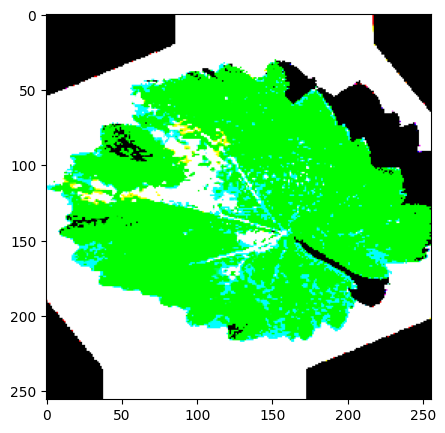

In [135]:
plotImage(t_img[:1], label[:1])

# Building Model

In [136]:
from keras.layers import Dense, Flatten
from keras.models import Model
from tensorflow.keras.applications import VGG19
import keras

In [137]:
base_model = VGG19(input_shape=(256,256,3), include_top=False)

In [138]:
for layer in base_model.layers:
    layer.trainable = False

In [139]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [140]:
X = Flatten()(base_model.output)
X = Dense(units=38, activation="softmax")(X)

#final model
model = Model(base_model.input, X)

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0   

In [141]:
import tensorflow as tf
tf.keras.losses.CategoricalCrossentropy()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## Early Stopping & Model Checkpoint

In [142]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
es = EarlyStopping(monitor='val_accuracy', min_delta=0.01, patience=3, verbose=1)
mc = ModelCheckpoint(filepath='best_model.h5', 
                     monitor='val_accuracy', 
                     min_delta=0.01, patience=3, 
                     verbose=1, 
                     save_best_only=True)


In [143]:
cb = [es,mc]

In [144]:

his = model.fit_generator(train, steps_per_epoch=16, epochs=50, verbose=1, callbacks=cb, validation_data=val, validation_steps=16)

C:\Users\codew\AppData\Local\Temp\ipykernel_11268\4120451982.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  his = model.fit_generator(train, steps_per_epoch=16, epochs=50, verbose=1, callbacks=cb, validation_data=val, validation_steps=16)


Epoch 1/50
16/16 [==============================] - ETA: 0s - loss: 25.7310 - accuracy: 0.1914
Epoch 1: val_accuracy improved from -inf to 0.36719, saving model to best_model.h5
16/16 [==============================] - 125s 8s/step - loss: 25.7310 - accuracy: 0.1914 - val_loss: 16.0756 - val_accuracy: 0.3672
Epoch 2/50
16/16 [==============================] - ETA: 0s - loss: 16.1417 - accuracy: 0.4238
Epoch 2: val_accuracy improved from 0.36719 to 0.50195, saving model to best_model.h5
16/16 [==============================] - 123s 8s/step - loss: 16.1417 - accuracy: 0.4238 - val_loss: 13.4471 - val_accuracy: 0.5020
Epoch 3/50
16/16 [==============================] - ETA: 0s - loss: 13.9025 - accuracy: 0.4961
Epoch 3: val_accuracy improved from 0.50195 to 0.63086, saving model to best_model.h5
16/16 [==============================] - 126s 8s/step - loss: 13.9025 - accuracy: 0.4961 - val_loss: 9.4045 - val_accuracy: 0.6309
Epoch 4/50
16/16 [==============================] - ETA: 0s - los

In [145]:

h = his.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

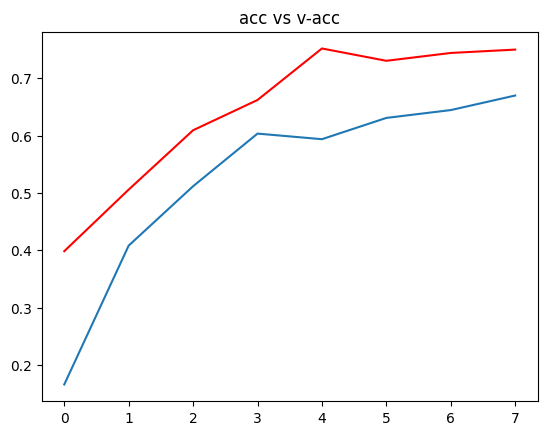

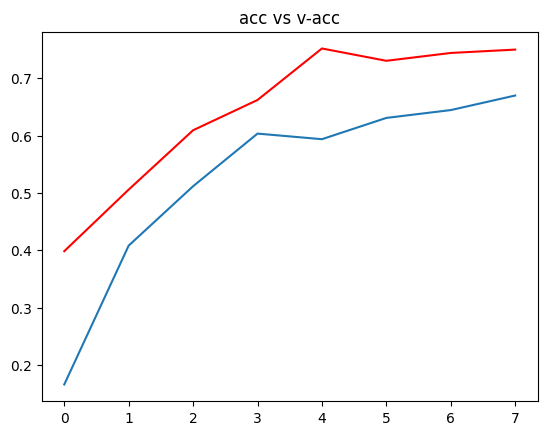

In [86]:
plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'], c = 'red')
plt.title("acc vs v-acc")
plt.show(())

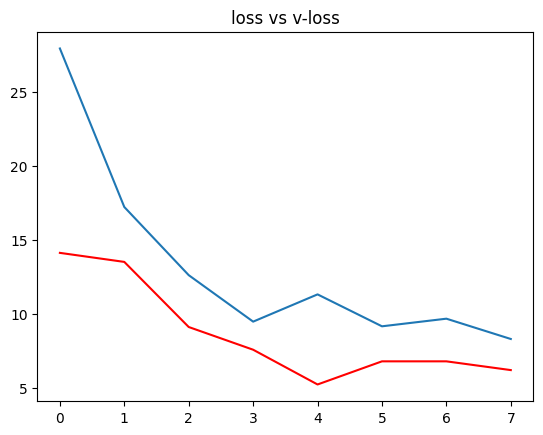

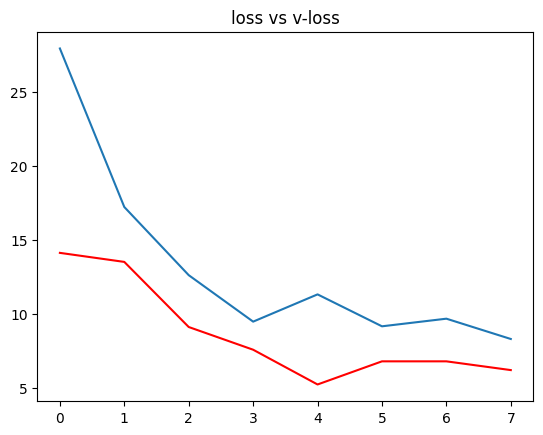

In [88]:
plt.plot(h['loss'])
plt.plot(h['val_loss'], c = 'red')
plt.title("loss vs v-loss")
plt.show(())

In [94]:
# load best model

from keras.models import load_model
model = load_model('./best_model.h5')

In [95]:
acc = model.evaluate(val)[1]
print(f"The accuracy is = {acc*100}%")

550/550 [==============================] - 2113s 4s/step - loss: 6.5430 - accuracy: 0.7276
The accuracy is = 72.75779843330383%


In [125]:
ref = dict(zip(list(train.class_indices.values()), list(train.class_indices.keys())))


In [126]:
def predection(path):
    img = load_img(path, target_size=(256,256))
    i = img_to_array(img)
    im = preprocess_input(i)
    img = np.expand_dims(im, axis=0)
    print(im.shape)
    pred = np.argmax(model.predict(img))
    print(f"The image belongs to {ref[pred]}")

In [128]:
path = './test/test/AppleCedarRust2.JPG'
predection(path)

(256, 256, 3)
1/1 [==============================] - 0s 185ms/step
The image belongs to Peach___Bacterial_spot
